# Variárives Globais

Quis definir aqui os valores usados para o calculo de cada função, já que fica mais facil para gerar os relatórios

In [25]:
# Valor Investido por Mês
valor_investido = 200

# Quantidade de anos investindo
qtd_anos_investindo = 10

# Valor do Rendimento do Investimento com Base no CDI
porcentagem_cdi = 100

# Valor de Acrescimo do Desafio das 52 Semanas
valor_acrescimo = 5

# Quantidade de semanas do desafio do investimento semanal (Desafio das 52 Semanas) para dar mais possibilidades
qdt_semanas_desafio = 52

# Data de inicio do desafio das 52 semanas
data_inicio_desafio = "2026-01-25"

# Protótipo de Investimento

Nessa área eu pretendo programar um protótipo de investimento ao longo do tempo, como por exemplo, um código que simula investimento ao longo do tempo e entrega um relatório completo da situação do investimento ao longo do tempo

## Importações

In [26]:
from __future__ import annotations

import argparse
import math
from dataclasses import dataclass
from datetime import date, datetime, timedelta
from typing import List, Dict, Tuple

import requests
import pandas as pd

## Implementação

In [27]:
# -----------------------------
# Impostos (modelo Brasil)
# -----------------------------
# IR regressivo (renda fixa em geral): 22,5% até 180d; 20% 181-360; 17,5% 361-720; 15% >720
def ir_aliquota_por_dias(dias: int) -> float:
    if dias <= 180:
        return 0.225
    if dias <= 360:
        return 0.20
    if dias <= 720:
        return 0.175
    return 0.15


# IOF regressivo sobre rendimento (somente se resgate <= 30 dias)
# Tabela padrão (dias: % do rendimento)
IOF_TABELA: Dict[int, float] = {
    1: 0.96, 2: 0.93, 3: 0.90, 4: 0.86, 5: 0.83,
    6: 0.80, 7: 0.76, 8: 0.73, 9: 0.70, 10: 0.66,
    11: 0.63, 12: 0.60, 13: 0.56, 14: 0.53, 15: 0.50,
    16: 0.46, 17: 0.43, 18: 0.40, 19: 0.36, 20: 0.33,
    21: 0.30, 22: 0.26, 23: 0.23, 24: 0.20, 25: 0.16,
    26: 0.13, 27: 0.10, 28: 0.06, 29: 0.03, 30: 0.00
}

def iof_aliquota_por_dias(dias: int) -> float:
    if dias <= 0:
        return 0.0
    if dias >= 30:
        return 0.0
    return IOF_TABELA.get(dias, 0.0)


# -----------------------------
# CDI (BCB/SGS)
# -----------------------------
def _fmt_bcb(d: date) -> str:
    # BCB usa dd/mm/aaaa
    return d.strftime("%d/%m/%Y")


def buscar_cdi_diario_bcb(data_inicial: date, data_final: date) -> pd.DataFrame:
    """
    Retorna CDI diário (% ao dia) da série SGS 12.
    """
    url = (
        "https://api.bcb.gov.br/dados/serie/bcdata.sgs.12/dados"
        f"?formato=json&dataInicial={_fmt_bcb(data_inicial)}&dataFinal={_fmt_bcb(data_final)}"
    )
    resp = requests.get(url, timeout=30)
    resp.raise_for_status()
    data = resp.json()

    if not data:
        raise RuntimeError("BCB não retornou dados de CDI para o intervalo informado.")

    rows = []
    for item in data:
        dt = datetime.strptime(item["data"], "%d/%m/%Y").date()
        val = float(str(item["valor"]).replace(",", "."))
        rows.append((dt, val))

    df = pd.DataFrame(rows, columns=["data", "cdi_diario_pct"])
    df.sort_values("data", inplace=True)
    df.reset_index(drop=True, inplace=True)
    return df


def obter_cdi_atual_diario_pct(janela_dias: int = 15) -> tuple[float, date]:
    """
    Pega o último CDI diário disponível (% ao dia).
    """
    hoje = date.today()
    ini = hoje - timedelta(days=janela_dias)
    df = buscar_cdi_diario_bcb(ini, hoje)
    last = df.iloc[-1]
    return float(last["cdi_diario_pct"]), last["data"]


In [28]:
# -----------------------------
# Simulação
# -----------------------------
@dataclass
class Lote:
    data_aporte: date
    principal: float
    saldo_bruto: float

def business_days_in_month(year: int, month: int) -> int:
    start = pd.Timestamp(year=year, month=month, day=1)
    end = (start + pd.offsets.MonthEnd(0))
    # Aproximação: dias úteis seg-sex (não considera feriados B3)
    bdays = pd.bdate_range(start, end).size
    return int(bdays)


def month_start_end(d: date) -> Tuple[date, date]:
    start = d.replace(day=1)
    # último dia do mês
    next_month = (start.replace(day=28) + timedelta(days=4)).replace(day=1)
    end = next_month - timedelta(days=1)
    return start, end


def add_months(d: date, months: int) -> date:
    # soma meses mantendo dia=1 no nosso uso (mais simples/estável)
    y = d.year + (d.month - 1 + months) // 12
    m = (d.month - 1 + months) % 12 + 1
    return date(y, m, 1)


def fator_mes_por_cdi_diario(cdi_diario_pct: float, pct_do_cdi: float, bdays: int) -> float:
    """
    CDI diário (% ao dia) -> fator do mês por composição em bdays.
    """
    r_d = (cdi_diario_pct * (pct_do_cdi / 100.0)) / 100.0  # decimal ao dia
    return (1.0 + r_d) ** bdays


def simular(
    aporte_mensal: float,
    anos: int,
    pct_do_cdi: float,
    data_inicio: date | None = None,
    base_anuais: int = 252,
    janela_cdi_dias: int = 15,
) -> pd.DataFrame:
    if aporte_mensal <= 0:
        raise ValueError("aporte_mensal deve ser > 0")
    if anos <= 0:
        raise ValueError("anos deve ser > 0")
    if pct_do_cdi <= 0:
        raise ValueError("pct_do_cdi deve ser > 0")

    if data_inicio is None:
        # começa no 1º dia do mês atual
        today = date.today()
        data_inicio = today.replace(day=1)

    cdi_diario_pct, cdi_data_ref = obter_cdi_atual_diario_pct(janela_dias=janela_cdi_dias)

    # anualizado só para mostrar (não precisa para o cálculo mensal)
    cdi_anualizado_pct = ((1 + (cdi_diario_pct/100)) ** base_anuais - 1) * 100

    total_meses = anos * 12
    lotes: List[Lote] = []
    linhas = []

    total_aportado = 0.0
    saldo_bruto_anterior = 0.0

    for i in range(total_meses):
        mes_ref = add_months(data_inicio, i)
        mes_ini, mes_fim = month_start_end(mes_ref)

        # 1) Aporte no início do mês (cresce 10% ao ano)
        ano_corrente = i // 12  # 0 no 1º ano, 1 no 2º, etc.
        aporte_mes = aporte_mensal * (1.10 ** ano_corrente)

        total_aportado += aporte_mes
        lotes.append(Lote(data_aporte=mes_ini, principal=aporte_mes, saldo_bruto=aporte_mes))


        # 2) Aplica rendimento bruto do mês
        bdays = business_days_in_month(mes_ini.year, mes_ini.month)
        fator = fator_mes_por_cdi_diario(cdi_diario_pct, pct_do_cdi, bdays)

        for lote in lotes:
            lote.saldo_bruto *= fator

        saldo_bruto = sum(l.saldo_bruto for l in lotes)
        rendimento_bruto_total = saldo_bruto - total_aportado

        # rendimento bruto do mês (aprox): variação do saldo bruto menos aporte do mês
        rendimento_bruto_mes = (saldo_bruto - saldo_bruto_anterior) - aporte_mes
        saldo_bruto_anterior = saldo_bruto

        # 3) Impostos estimados SE resgatasse no fim do mês:
        # Modelo: IOF (se <30d) sobre rendimento do lote; IR sobre (rendimento - IOF) do lote.
        imposto_iof_total = 0.0
        imposto_ir_total = 0.0

        for lote in lotes:
            dias = (mes_fim - lote.data_aporte).days
            rendimento_lote = max(0.0, lote.saldo_bruto - lote.principal)

            iof_rate = iof_aliquota_por_dias(dias)
            iof = rendimento_lote * iof_rate

            ir_rate = ir_aliquota_por_dias(dias)
            base_ir = max(0.0, rendimento_lote - iof)
            ir = base_ir * ir_rate

            imposto_iof_total += iof
            imposto_ir_total += ir

        imposto_total = imposto_iof_total + imposto_ir_total
        saldo_liquido = saldo_bruto - imposto_total
        rendimento_liquido_total = saldo_liquido - total_aportado
        rendimento_liquido_mes = rendimento_bruto_mes  # aproximação
        # Se quiser, dá para calcular rendimento líquido do mês com a diferença mês a mês também (mais verboso).

        linhas.append({
            "mes": i + 1,
            "competencia": mes_ini.strftime("%Y-%m"),
            "data_inicio_mes": mes_ini.isoformat(),
            "data_fim_mes": mes_fim.isoformat(),
            "aporte_mes": round(aporte_mes, 2),
            "total_aportado": round(total_aportado, 2),

            "cdi_diario_pct_usado": round(cdi_diario_pct, 6),
            "cdi_anualizado_pct_aprox": round(cdi_anualizado_pct, 4),
            "cdi_data_referencia": cdi_data_ref.isoformat(),
            "pct_do_cdi": round(pct_do_cdi, 2),
            "dias_uteis_mes_aprox": bdays,
            "fator_mes_bruto": round(fator, 10),

            "rendimento_bruto_mes": round(rendimento_bruto_mes, 2),
            "saldo_bruto": round(saldo_bruto, 2),
            "rendimento_bruto_total": round(rendimento_bruto_total, 2),

            "imposto_iof_estimado": round(imposto_iof_total, 2),
            "imposto_ir_estimado": round(imposto_ir_total, 2),
            "imposto_total_estimado": round(imposto_total, 2),

            "saldo_liquido_estimado_resgate": round(saldo_liquido, 2),
            "rendimento_liquido_total_estimado": round(rendimento_liquido_total, 2),
        })

    return pd.DataFrame(linhas)

In [29]:
def rodar_projecao_jupyter(
    aporte=200.0,
    anos=3,
    pct_cdi=100.0,
    inicio=None,
    base_anuais=252,
    janela_cdi=15,
    salvar_csv=False,
    caminho_csv="projecao_cdi.csv"
):
    """
    Executa a simulação e retorna um DataFrame pandas.
    
    Parâmetros:
    ----------
    aporte : float
        Valor mensal investido.
    anos : int
        Quantidade de anos da projeção.
    pct_cdi : float
        Percentual do CDI (ex: 100, 110).
    inicio : str ou None
        Data inicial no formato 'YYYY-MM-01'. Se None, usa mês atual.
    base_anuais : int
        Base de dias úteis do ano (padrão 252).
    janela_cdi : int
        Janela em dias para buscar o CDI mais recente.
    salvar_csv : bool
        Se True, salva o CSV.
    caminho_csv : str
        Caminho do arquivo CSV.
    """

    from datetime import datetime
    
    # Converte data se fornecida
    data_inicio = None
    if inicio:
        data_inicio = datetime.strptime(inicio, "%Y-%m-%d").date()
        data_inicio = data_inicio.replace(day=1)

    # Executa simulação
    df = simular(
        aporte_mensal=aporte,
        anos=anos,
        pct_do_cdi=pct_cdi,
        data_inicio=data_inicio,
        base_anuais=base_anuais,
        janela_cdi_dias=janela_cdi,
    )

    # Salvar CSV (opcional)
    if salvar_csv:
        df.to_csv(caminho_csv, index=False, encoding="utf-8")
        print(f"CSV salvo em: {caminho_csv}")

    return df

## Área de Execução

In [30]:
%%time
# Executa a projeção
df_projecao = rodar_projecao_jupyter(
    aporte=valor_investido,
    anos=qtd_anos_investindo,
    pct_cdi=porcentagem_cdi,
    inicio="2026-02-01",
    salvar_csv=True
)

df_projecao.head()

CSV salvo em: projecao_cdi.csv
CPU times: total: 46.9 ms
Wall time: 231 ms


,mes,competencia,data_inicio_mes,data_fim_mes,aporte_mes,total_aportado,cdi_diario_pct_usado,cdi_anualizado_pct_aprox,cdi_data_referencia,pct_do_cdi,dias_uteis_mes_aprox,fator_mes_bruto,rendimento_bruto_mes,saldo_bruto,rendimento_bruto_total,imposto_iof_estimado,imposto_ir_estimado,imposto_total_estimado,saldo_liquido_estimado_resgate,rendimento_liquido_total_estimado
0,1,2026-02,2026-02-01,2026-02-28,200.0,200.0,0.055131,14.9,2026-02-10,100,20,1.011084,2.22,202.22,2.22,0.22,0.45,0.67,201.55,1.55
1,2,2026-03,2026-03-01,2026-03-31,200.0,400.0,0.055131,14.9,2026-02-10,100,22,1.012199,4.91,407.12,7.12,0.00,1.60,1.60,405.52,5.52
2,3,2026-04,2026-04-01,2026-04-30,200.0,600.0,0.055131,14.9,2026-02-10,100,22,1.012199,7.41,614.53,14.53,0.07,3.25,3.33,611.20,11.20
3,4,2026-05,2026-05-01,2026-05-31,200.0,800.0,0.055131,14.9,2026-02-10,100,21,1.011642,9.48,824.01,24.01,0.00,5.40,5.40,818.61,18.61
4,5,2026-06,2026-06-01,2026-06-30,200.0,1000.0,0.055131,14.9,2026-02-10,100,22,1.012199,12.49,1036.50,36.50,0.07,8.20,8.27,1028.23,28.23


CPU times: total: 31.2 ms
Wall time: 26.9 ms


<Axes: xlabel='mes'>

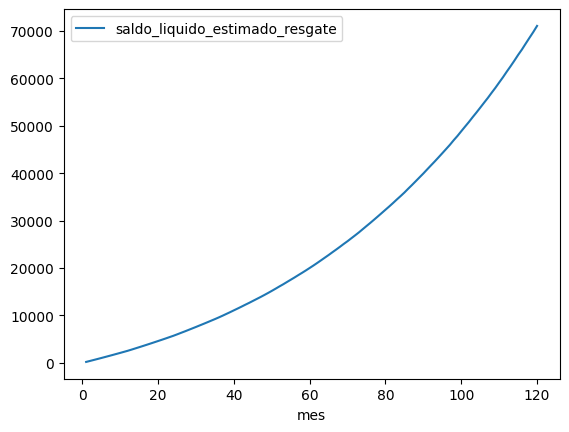

In [31]:
%%time
df_projecao.describe()
df_projecao.plot(x="mes", y="saldo_liquido_estimado_resgate")

# Implementação de Relatório

Nessa sessão é projetado um código que gera um relatório da simulação de investimentos ao longo do tempo.

## Importações

In [34]:
import os
from datetime import datetime

import pandas as pd
import matplotlib.pyplot as plt
import math

from reportlab.lib import colors
from reportlab.lib.pagesizes import A4
from reportlab.lib.units import cm
from reportlab.lib.styles import getSampleStyleSheet, ParagraphStyle
from reportlab.platypus import (
    SimpleDocTemplate, Paragraph, Spacer, Table, TableStyle,
    PageBreak, Image, KeepTogether
)
from reportlab.platypus.flowables import HRFlowable

## Implementação

In [35]:
# -------------------------
# Helpers de formatação
# -------------------------
def _brl(x):
    try:
        return f"R$ {float(x):,.2f}".replace(",", "X").replace(".", ",").replace("X", ".")
    except Exception:
        return str(x)

def _pct(x):
    try:
        return f"{float(x):.2f}%".replace(".", ",")
    except Exception:
        return str(x)

def _safe_col(df, col, default=0.0):
    return df[col] if col in df.columns else pd.Series([default] * len(df))

def _ensure_dir(path):
    os.makedirs(path, exist_ok=True)

def _set_xticks_dinamicos(x, max_labels: int = 24, rotation: int = 45):
    """
    Ajusta os labels do eixo X para não poluir quando há muitos meses.
    - Se len(x) <= max_labels: mostra todos.
    - Se len(x) > max_labels: mostra 1 label a cada k pontos.
    """
    n = len(x)
    if n == 0:
        return

    # k = espaçamento entre labels
    k = 1 if n <= max_labels else int(math.ceil(n / max_labels))

    # cria lista de labels com "" nos pontos intermediários
    labels = [str(v) if (i % k == 0 or i == n - 1) else "" for i, v in enumerate(x)]

    plt.xticks(range(n), labels, rotation=rotation, ha="right")

In [36]:
# -------------------------
# Gráficos (Matplotlib)
# -------------------------
def gerar_graficos(df: pd.DataFrame, out_dir: str):
    """
    Gera PNGs de gráficos no diretório out_dir e retorna dict com caminhos.
    """
    _ensure_dir(out_dir)

    # Ajusta eixo de tempo
    # Espera "competencia" no formato YYYY-MM
    if "competencia" in df.columns:
        x = df["competencia"].astype(str).tolist()  # labels
        x_idx = list(range(len(x)))                 # eixo numérico
    else:
        # fallback: mes (1..N)
        x_idx = (df.index + 1).tolist()
        x = [str(v) for v in x_idx]

    caminhos = {}

    # 1) Evolução: total aportado vs saldo bruto vs saldo líquido estimado
    fig = plt.figure(figsize=(10, 4.8))
    plt.plot(x_idx, _safe_col(df, "total_aportado"), label="Total aportado")
    plt.plot(x_idx, _safe_col(df, "saldo_bruto"), label="Saldo bruto")
    plt.plot(x_idx, _safe_col(df, "saldo_liquido_estimado_resgate"), label="Saldo líquido estimado (resgate)")
    _set_xticks_dinamicos(x, max_labels=24)
    plt.title("Evolução do investimento")
    plt.xlabel("Mês/Ano")
    plt.ylabel("Valor (R$)")
    plt.legend()
    plt.tight_layout()
    p = os.path.join(out_dir, "graf_evolucao.png")
    plt.savefig(p, dpi=200)
    plt.close(fig)
    caminhos["evolucao"] = p

    # 2) Rendimento bruto do mês
    fig = plt.figure(figsize=(10, 4.2))
    plt.bar(x_idx, _safe_col(df, "rendimento_bruto_mes"))
    _set_xticks_dinamicos(x, max_labels=24)
    plt.title("Rendimento bruto por mês (aprox.)")
    plt.xlabel("Mês/Ano")
    plt.ylabel("Rendimento (R$)")
    plt.tight_layout()
    p = os.path.join(out_dir, "graf_rendimento_mes.png")
    plt.savefig(p, dpi=200)
    plt.close(fig)
    caminhos["rendimento_mes"] = p

    # 3) Impostos estimados (IOF + IR) por mês (se resgatar naquele mês)
    fig = plt.figure(figsize=(10, 4.2))
    impostos_total = _safe_col(df, "imposto_total_estimado")
    plt.bar(x_idx, impostos_total)
    _set_xticks_dinamicos(x, max_labels=24)
    plt.title("Imposto estimado por mês (IOF + IR) - se resgatar no mês")
    plt.xlabel("Mês/Ano")
    plt.ylabel("Imposto (R$)")
    plt.tight_layout()
    p = os.path.join(out_dir, "graf_impostos.png")
    plt.savefig(p, dpi=200)
    plt.close(fig)
    caminhos["impostos"] = p

    # 4) Aporte por mês (útil quando o aporte varia ao longo do tempo, ex.: +10% a.a.)
    fig = plt.figure(figsize=(10, 4.2))
    plt.bar(x_idx, _safe_col(df, "aporte_mes"))
    _set_xticks_dinamicos(x, max_labels=24)
    plt.title("Aporte por mês")
    plt.xlabel("Mês/Ano")
    plt.ylabel("Aporte (R$)")
    plt.tight_layout()
    p = os.path.join(out_dir, "graf_aporte.png")
    plt.savefig(p, dpi=200)
    plt.close(fig)
    caminhos["aporte_mes"] = p

    return caminhos

In [37]:
# -------------------------
# PDF (ReportLab)
# -------------------------
def _header_footer(canvas, doc, titulo="Relatório de Projeção - Renda Fixa (CDI)"):
    canvas.saveState()
    w, h = A4

    # Cabeçalho
    canvas.setFont("Helvetica-Bold", 9)
    canvas.setFillColor(colors.HexColor("#1f2937"))
    canvas.drawString(2.0 * cm, h - 1.2 * cm, titulo)

    # Rodapé
    canvas.setFont("Helvetica", 8)
    canvas.setFillColor(colors.HexColor("#6b7280"))
    now = datetime.now().strftime("%Y-%m-%d %H:%M")
    canvas.drawString(2.0 * cm, 1.0 * cm, f"Gerado em: {now}")
    canvas.drawRightString(w - 2.0 * cm, 1.0 * cm, f"Página {doc.page}")

    canvas.restoreState()


def _card_table(rows, col_widths, accent="#2563eb"):
    """
    Pequena tabela estilo "cards" (2 colunas) para métricas.
    rows: lista de [label, value]
    """
    t = Table(rows, colWidths=col_widths, hAlign="LEFT")
    t.setStyle(TableStyle([
        ("BACKGROUND", (0, 0), (-1, -1), colors.white),
        ("BOX", (0, 0), (-1, -1), 0.8, colors.HexColor("#e5e7eb")),
        ("INNERGRID", (0, 0), (-1, -1), 0.3, colors.HexColor("#e5e7eb")),
        ("FONTNAME", (0, 0), (0, -1), "Helvetica-Bold"),
        ("FONTNAME", (1, 0), (1, -1), "Helvetica"),
        ("FONTSIZE", (0, 0), (-1, -1), 9),
        ("TEXTCOLOR", (0, 0), (0, -1), colors.HexColor(accent)),
        ("TEXTCOLOR", (1, 0), (1, -1), colors.HexColor("#111827")),
        ("VALIGN", (0, 0), (-1, -1), "MIDDLE"),
        ("LEFTPADDING", (0, 0), (-1, -1), 8),
        ("RIGHTPADDING", (0, 0), (-1, -1), 8),
        ("TOPPADDING", (0, 0), (-1, -1), 6),
        ("BOTTOMPADDING", (0, 0), (-1, -1), 6),
    ]))
    return t


def gerar_relatorio_pdf_do_csv(
    caminho_csv: str,
    caminho_pdf: str = "relatorio_investimento_cdi.pdf",
    titulo: str = "Relatório de Projeção de Investimento (CDI)",
    pasta_assets: str = "_assets_relatorio",
    linhas_tabela_por_pagina: int = 35,
):
    """
    Lê o CSV de projeção e gera um PDF detalhado (tabelas, gráficos e textos).
    """
    df = pd.read_csv(caminho_csv)

    # Gráficos
    assets_dir = os.path.join(os.path.dirname(caminho_pdf) or ".", pasta_assets)
    grafs = gerar_graficos(df, assets_dir)

    # Estilos
    styles = getSampleStyleSheet()
    styles.add(ParagraphStyle(
        name="TitleBig",
        parent=styles["Title"],
        fontName="Helvetica-Bold",
        fontSize=20,
        leading=24,
        textColor=colors.HexColor("#111827"),
        spaceAfter=10
    ))
    styles.add(ParagraphStyle(
        name="H2",
        parent=styles["Heading2"],
        fontName="Helvetica-Bold",
        textColor=colors.HexColor("#111827"),
        spaceBefore=10,
        spaceAfter=6
    ))
    styles.add(ParagraphStyle(
        name="Body",
        parent=styles["BodyText"],
        fontName="Helvetica",
        fontSize=10,
        leading=14,
        textColor=colors.HexColor("#111827")
    ))
    styles.add(ParagraphStyle(
        name="Muted",
        parent=styles["BodyText"],
        fontName="Helvetica",
        fontSize=9,
        leading=12,
        textColor=colors.HexColor("#6b7280")
    ))

    # Campos esperados no CSV (com fallback)
    # Agora "aporte_mes" pode variar ao longo do tempo (ex.: +10% a.a.)
    if "aporte_mes" in df.columns:
        aporte_inicial = float(_safe_col(df, "aporte_mes").iloc[0])
        aporte_final = float(_safe_col(df, "aporte_mes").iloc[-1])
        aporte_medio = float(_safe_col(df, "aporte_mes").mean())
    else:
        aporte_inicial = aporte_final = aporte_medio = None

    # Se você quiser, pode expor isso como parâmetro; por ora, fixa em 10% conforme regra definida
    crescimento_aporte_aa_pct = 10.0

    pct_cdi = float(_safe_col(df, "pct_do_cdi").iloc[0]) if "pct_do_cdi" in df.columns else None

    cdi_diario = float(_safe_col(df, "cdi_diario_pct_usado").iloc[0]) if "cdi_diario_pct_usado" in df.columns else None
    cdi_anual = float(_safe_col(df, "cdi_anualizado_pct_aprox").iloc[0]) if "cdi_anualizado_pct_aprox" in df.columns else None
    
    cdi_ref = str(_safe_col(df, "cdi_data_referencia", "").iloc[0]) if "cdi_data_referencia" in df.columns else ""


    total_aportado_final = float(_safe_col(df, "total_aportado").iloc[-1]) if "total_aportado" in df.columns else None
    saldo_bruto_final = float(_safe_col(df, "saldo_bruto").iloc[-1]) if "saldo_bruto" in df.columns else None
    imposto_total_final = float(_safe_col(df, "imposto_total_estimado").iloc[-1]) if "imposto_total_estimado" in df.columns else None
    saldo_liquido_final = float(_safe_col(df, "saldo_liquido_estimado_resgate").iloc[-1]) if "saldo_liquido_estimado_resgate" in df.columns else None
    rendimento_bruto_total_final = float(_safe_col(df, "rendimento_bruto_total").iloc[-1]) if "rendimento_bruto_total" in df.columns else None
    rendimento_liq_total_final = float(_safe_col(df, "rendimento_liquido_total_estimado").iloc[-1]) if "rendimento_liquido_total_estimado" in df.columns else None

    # Documento
    doc = SimpleDocTemplate(
        caminho_pdf,
        pagesize=A4,
        leftMargin=2.0 * cm,
        rightMargin=2.0 * cm,
        topMargin=2.0 * cm,
        bottomMargin=1.6 * cm
    )

    story = []

    # Capa
    story.append(Paragraph(titulo, styles["TitleBig"]))
    story.append(Paragraph(
        "Este relatório foi gerado a partir do CSV de projeção mensal do investimento atrelado ao CDI. "
        "Os impostos (IOF/IR) apresentados são estimativas considerando um resgate hipotético no fim de cada mês. "
        "Nesta simulação, o aporte mensal pode variar ao longo do tempo (ex.: crescimento anual do valor investido).",
        styles["Body"]
    ))
    story.append(Spacer(1, 10))
    story.append(HRFlowable(width="100%", thickness=1, color=colors.HexColor("#e5e7eb")))
    story.append(Spacer(1, 12))

    # Resumo em "cards"
    resumo_rows = [
        ["Aporte inicial (mês 1)", _brl(aporte_inicial) if aporte_inicial is not None else "-"],
        ["Aporte final (último mês)", _brl(aporte_final) if aporte_final is not None else "-"],
        ["Aporte médio mensal (período)", _brl(aporte_medio) if aporte_medio is not None else "-"],
        ["Crescimento do aporte", f"{crescimento_aporte_aa_pct:.2f}% a.a."],
        ["Percentual do CDI", _pct(pct_cdi) if pct_cdi is not None else "-"],
    
        ["CDI diário usado (a.d.)", _pct(cdi_diario) if cdi_diario is not None else "-"],
        ["CDI anualizado aprox. (a.a.)", _pct(cdi_anual) if cdi_anual is not None else "-"],
    
        ["Data ref. CDI", cdi_ref or "-"],
        ["Total aportado (final)", _brl(total_aportado_final) if total_aportado_final is not None else "-"],
        ["Saldo bruto (final)", _brl(saldo_bruto_final) if saldo_bruto_final is not None else "-"],
        ["Imposto estimado (final)", _brl(imposto_total_final) if imposto_total_final is not None else "-"],
        ["Saldo líquido est. (final)", _brl(saldo_liquido_final) if saldo_liquido_final is not None else "-"],
        ["Rendimento bruto total (final)", _brl(rendimento_bruto_total_final) if rendimento_bruto_total_final is not None else "-"],
        ["Rendimento líquido total est. (final)", _brl(rendimento_liq_total_final) if rendimento_liq_total_final is not None else "-"],
    ]

    story.append(Paragraph("Resumo executivo", styles["H2"]))
    story.append(_card_table(resumo_rows, col_widths=[6.2 * cm, 9.6 * cm]))
    story.append(Spacer(1, 10))
    story.append(Paragraph(
        "Nota: o CDI futuro é incerto; esta projeção considera o CDI/DI diário mais recente disponível no momento da geração do CSV "
        "e assume a mesma taxa diária ao longo do horizonte. O valor anualizado exibido é apenas uma conversão aproximada "
        "(por composição) para facilitar comparação com sites que mostram CDI a.a..",
        styles["Muted"]
    ))

    story.append(PageBreak())

    # Seção de gráficos
    story.append(Paragraph("Gráficos", styles["H2"]))
    story.append(Paragraph(
        "Os gráficos abaixo ajudam a visualizar a evolução do saldo, a variação do rendimento mensal e a carga tributária estimada "
        "caso o investimento fosse resgatado em cada mês.",
        styles["Body"]
    ))
    story.append(Spacer(1, 10))

    def add_img(path, caption):
        if not os.path.exists(path):
            story.append(Paragraph(f"(Gráfico ausente) {caption}", styles["Muted"]))
            return
        img = Image(path)
        img.drawHeight = 7.0 * cm
        img.drawWidth = 17.0 * cm
        story.append(KeepTogether([
            img,
            Spacer(1, 4),
            Paragraph(caption, styles["Muted"]),
            Spacer(1, 10),
        ]))

    add_img(grafs.get("evolucao", ""), "Figura 1 - Evolução do investimento: aportes, saldo bruto e saldo líquido estimado.")
    add_img(grafs.get("aporte_mes", ""), "Figura 2 - Aporte por mês (com variação ao longo do tempo, ex.: crescimento anual).")
    add_img(grafs.get("rendimento_mes", ""), "Figura 3 - Rendimento bruto mensal (aproximação).")
    add_img(grafs.get("impostos", ""), "Figura 4 - Imposto estimado (IOF + IR) caso haja resgate no mês.")
    story.append(PageBreak())

    # Tabela detalhada mês a mês
    story.append(Paragraph("Tabela detalhada mês a mês", styles["H2"]))
    story.append(Paragraph(
        "A tabela apresenta os valores da projeção para cada competência (mês/ano), incluindo o aporte do mês, "
        "total acumulado investido, rendimento bruto do mês, saldo bruto, impostos estimados para resgate no mês e saldo líquido estimado.",
        styles["Body"]
    ))
    story.append(Spacer(1, 8))

    # Monta tabela com colunas essenciais (e alguns extras úteis)
    # (Se alguma coluna não existir, criamos vazia.)
    cols = [
        ("competencia", "Mês/Ano"),
        ("aporte_mes", "Aporte"),
        ("total_aportado", "Total investido"),
        ("rendimento_bruto_mes", "Rend. bruto mês"),
        ("saldo_bruto", "Saldo bruto"),
        ("imposto_total_estimado", "Imposto (est.)"),
        ("saldo_liquido_estimado_resgate", "Saldo líquido (est.)"),
        ("cdi_anualizado_pct_aprox", "CDI a.a. (aprox)"),
    ]
    for c, _ in cols:
        if c not in df.columns:
            df[c] = 0.0

    # Formatação para exibição
    df_fmt = df.copy()
    df_fmt["aporte_mes"] = df_fmt["aporte_mes"].map(_brl)
    df_fmt["total_aportado"] = df_fmt["total_aportado"].map(_brl)
    df_fmt["rendimento_bruto_mes"] = df_fmt["rendimento_bruto_mes"].map(_brl)
    df_fmt["saldo_bruto"] = df_fmt["saldo_bruto"].map(_brl)
    df_fmt["imposto_total_estimado"] = df_fmt["imposto_total_estimado"].map(_brl)
    df_fmt["saldo_liquido_estimado_resgate"] = df_fmt["saldo_liquido_estimado_resgate"].map(_brl)
    df_fmt["cdi_anualizado_pct_aprox"] = df_fmt["cdi_anualizado_pct_aprox"].map(_pct)

    headers = [label for _, label in cols]
    data_all = [headers] + df_fmt[[c for c, _ in cols]].values.tolist()

    col_widths = [
        2.0*cm,  # Mês/Ano
        2.2*cm,  # Aporte
        2.6*cm,  # Total investido
        2.6*cm,  # Rend mês
        2.6*cm,  # Saldo bruto
        2.4*cm,  # Imposto
        2.8*cm,  # Saldo líquido
        1.8*cm,  # CDI a.a.
    ]

    # Tabela única (ReportLab pagina automaticamente)
    table_data = [headers] + df_fmt[[c for c, _ in cols]].values.tolist()
    
    t = Table(table_data, colWidths=col_widths, repeatRows=1)
    t.setStyle(TableStyle([
        ("BACKGROUND", (0, 0), (-1, 0), colors.HexColor("#111827")),
        ("TEXTCOLOR", (0, 0), (-1, 0), colors.white),
        ("FONTNAME", (0, 0), (-1, 0), "Helvetica-Bold"),
        ("FONTSIZE", (0, 0), (-1, 0), 9),
    
        ("ALIGN", (1, 1), (-1, -1), "RIGHT"),
        ("ALIGN", (0, 0), (0, -1), "LEFT"),
        ("FONTSIZE", (0, 1), (-1, -1), 8.5),
        ("FONTNAME", (0, 1), (-1, -1), "Helvetica"),
    
        ("GRID", (0, 0), (-1, -1), 0.25, colors.HexColor("#e5e7eb")),
        ("ROWBACKGROUNDS", (0, 1), (-1, -1), [colors.white, colors.HexColor("#f9fafb")]),
        ("LEFTPADDING", (0, 0), (-1, -1), 5),
        ("RIGHTPADDING", (0, 0), (-1, -1), 5),
        ("TOPPADDING", (0, 0), (-1, -1), 4),
        ("BOTTOMPADDING", (0, 0), (-1, -1), 4),
    ]))
    
    story.append(t)

    # Rodapé final / observações
    story.append(PageBreak())
    story.append(Paragraph("Observações e premissas", styles["H2"]))
    story.append(Paragraph(
        "<b>1)</b> CDI futuro é desconhecido: a projeção usa a taxa indicada no CSV para todos os meses.<br/>"
        "<b>2)</b> Aportes podem variar ao longo do tempo: a coluna <i>aporte_mes</i> do CSV define o valor investido em cada competência "
        f"(neste cenário, crescimento de {crescimento_aporte_aa_pct:.2f}% a.a. do aporte).<br/>"
        "<b>3)</b> Impostos são estimativas de resgate no mês: IOF regressivo até 30 dias (sobre rendimento) e IR regressivo "
        "(sobre rendimento líquido de IOF).<br/>"
        "<b>4)</b> Dias úteis do mês podem ter aproximação caso o CSV tenha sido gerado sem feriados específicos.<br/>"
        "<b>5)</b> Este relatório não constitui recomendação de investimento; serve para simulação e planejamento.",
        styles["Body"]
    ))

    # Build
    doc.build(
        story,
        onFirstPage=lambda c, d: _header_footer(c, d, titulo=titulo),
        onLaterPages=lambda c, d: _header_footer(c, d, titulo=titulo),
    )

    return caminho_pdf

## Área de Execução

In [38]:
%%time
pdf_path = gerar_relatorio_pdf_do_csv(
    caminho_csv="projecao_cdi.csv",
    caminho_pdf="relatorio_cdi.pdf"
)
pdf_path

CPU times: total: 1.73 s
Wall time: 1.8 s


'relatorio_cdi.pdf'

# Analise de Erro de Recuperação do CDI

In [14]:
import requests
import pandas as pd
from datetime import date, timedelta, datetime

def obter_cdi_diario_bcb(janela_dias=15):
    """
    Busca o CDI/DI diário na série SGS 12 (BCB) e retorna o último valor disponível.
    Retorna: (data_ref, cdi_diario_pct)
    """
    hoje = date.today()
    ini = hoje - timedelta(days=janela_dias)

    url = (
        "https://api.bcb.gov.br/dados/serie/bcdata.sgs.12/dados"
        f"?formato=json&dataInicial={ini.strftime('%d/%m/%Y')}&dataFinal={hoje.strftime('%d/%m/%Y')}"
    )

    r = requests.get(url, timeout=30)
    r.raise_for_status()
    data = r.json()
    if not data:
        raise RuntimeError("Sem dados retornados pelo BCB para o intervalo informado.")

    df = pd.DataFrame(data)
    df["data"] = pd.to_datetime(df["data"], format="%d/%m/%Y").dt.date
    df["valor"] = df["valor"].astype(str).str.replace(",", ".", regex=False).astype(float)

    # último registro disponível
    last = df.sort_values("data").iloc[-1]
    return last["data"], last["valor"]  # valor em % ao dia


def anualizar_taxa_diaria(cdi_diario_pct, base_dias_uteis_ano=252):
    """
    Converte % ao dia em % ao ano (a.a.) por capitalização composta.
    """
    r_d = cdi_diario_pct / 100.0
    r_aa = (1 + r_d) ** base_dias_uteis_ano - 1
    return r_aa * 100


def mensal_aprox_por_taxa_diaria(cdi_diario_pct, dias_uteis_mes=21):
    """
    Aproxima CDI mensal (% a.m.) usando uma quantidade média de dias úteis.
    """
    r_d = cdi_diario_pct / 100.0
    r_am = (1 + r_d) ** dias_uteis_mes - 1
    return r_am * 100


# --- Executar e exibir ---
data_ref, cdi_diario = obter_cdi_diario_bcb(janela_dias=30)
cdi_aa = anualizar_taxa_diaria(cdi_diario, base_dias_uteis_ano=252)
cdi_am_aprox = mensal_aprox_por_taxa_diaria(cdi_diario, dias_uteis_mes=21)

resultado = pd.DataFrame([{
    "data_referencia": data_ref.isoformat(),
    "CDI_diario_%": cdi_diario,            # % a.d.
    "CDI_anualizado_%_aa": cdi_aa,         # % a.a. (aprox)
    "CDI_mensal_aprox_%_am": cdi_am_aprox  # % a.m. (aprox)
}])

resultado

,data_referencia,CDI_diario_%,CDI_anualizado_%_aa,CDI_mensal_aprox_%_am
0,2026-02-10,0.055131,14.899981,1.164156


# Protótipo do Desafio das 52 Semanas

Nessa implementação, quero implemetar a geração de relatório de investimento no desafio das 52 semanas, para a pessoa conseguir ver o resultado do seu investimento antes de fazer.

## Importações

In [15]:
from __future__ import annotations

from dataclasses import dataclass
from datetime import date, datetime, timedelta
from typing import List, Dict, Tuple, Optional

import pandas as pd
import requests

## Implementação

In [16]:
# -----------------------------
# IOF e IR (mesma lógica)
# -----------------------------
IOF_TABELA: Dict[int, float] = {
    1: 0.96, 2: 0.93, 3: 0.90, 4: 0.86, 5: 0.83,
    6: 0.80, 7: 0.76, 8: 0.73, 9: 0.70, 10: 0.66,
    11: 0.63, 12: 0.60, 13: 0.56, 14: 0.53, 15: 0.50,
    16: 0.46, 17: 0.43, 18: 0.40, 19: 0.36, 20: 0.33,
    21: 0.30, 22: 0.26, 23: 0.23, 24: 0.20, 25: 0.16,
    26: 0.13, 27: 0.10, 28: 0.06, 29: 0.03, 30: 0.00
}

def iof_aliquota_por_dias(dias: int) -> float:
    if dias <= 0:
        return 0.0
    if dias >= 30:
        return 0.0
    return IOF_TABELA.get(dias, 0.0)

def ir_aliquota_por_dias(dias: int) -> float:
    if dias <= 180:
        return 0.225
    if dias <= 360:
        return 0.20
    if dias <= 720:
        return 0.175
    return 0.15

In [17]:
# -----------------------------
# CDI Diário (BCB/SGS 12)
# -----------------------------
def _fmt_bcb(d: date) -> str:
    return d.strftime("%d/%m/%Y")

def buscar_cdi_diario_bcb(data_inicial: date, data_final: date) -> pd.DataFrame:
    url = (
        "https://api.bcb.gov.br/dados/serie/bcdata.sgs.12/dados"
        f"?formato=json&dataInicial={_fmt_bcb(data_inicial)}&dataFinal={_fmt_bcb(data_final)}"
    )
    r = requests.get(url, timeout=30)
    r.raise_for_status()
    data = r.json()
    if not data:
        raise RuntimeError("BCB não retornou dados de CDI no intervalo informado.")

    df = pd.DataFrame(data)
    df["data"] = pd.to_datetime(df["data"], format="%d/%m/%Y").dt.date
    df["valor"] = df["valor"].astype(str).str.replace(",", ".", regex=False).astype(float)
    df.sort_values("data", inplace=True)
    df.rename(columns={"valor": "cdi_diario_pct"}, inplace=True)
    return df[["data", "cdi_diario_pct"]].reset_index(drop=True)

def obter_cdi_atual_diario_pct(janela_dias: int = 30) -> Tuple[float, date]:
    hoje = date.today()
    ini = hoje - timedelta(days=janela_dias)
    df = buscar_cdi_diario_bcb(ini, hoje)
    last = df.iloc[-1]
    return float(last["cdi_diario_pct"]), last["data"]

def anualizar_cdi_diario(cdi_diario_pct: float, base_anuais: int = 252) -> float:
    r_d = cdi_diario_pct / 100.0
    r_aa = (1 + r_d) ** base_anuais - 1
    return r_aa * 100

In [18]:
# -----------------------------
# Simulação Semanal (52 semanas)
# -----------------------------
@dataclass
class Lote:
    data_aporte: date
    principal: float
    saldo_bruto: float

def fator_semana_por_cdi_diario(cdi_diario_pct: float, pct_do_cdi: float, dias_uteis_semana: int = 5) -> float:
    """
    CDI diário (% a.d.) -> fator semanal por composição.
    """
    r_d = (cdi_diario_pct * (pct_do_cdi / 100.0)) / 100.0
    return (1.0 + r_d) ** dias_uteis_semana

def proxima_segunda(d: date) -> date:
    # 0=segunda ... 6=domingo
    offset = (0 - d.weekday()) % 7
    return d + timedelta(days=offset)

def simular_desafio_52_semanas(
    acrescimo_semanal: float,
    semanas: int = 52,
    pct_do_cdi: float = 100.0,
    inicio: Optional[str] = None,  # "YYYY-MM-DD"
    dias_uteis_semana: int = 5,
    janela_cdi_dias: int = 30,
    base_anuais: int = 252,
) -> pd.DataFrame:
    """
    Desafio: semana 1 aporta 1*acrescimo; semana 2 aporta 2*acrescimo; ... semana n aporta n*acrescimo
    Aporte no início da semana (segunda). Rendimento semanal composto.
    """
    if acrescimo_semanal <= 0:
        raise ValueError("acrescimo_semanal deve ser > 0")
    if semanas <= 0:
        raise ValueError("semanas deve ser > 0")

    if inicio:
        dt = datetime.strptime(inicio, "%Y-%m-%d").date()
    else:
        dt = date.today()

    # padroniza para começar numa segunda-feira
    data_inicio = proxima_segunda(dt)

    cdi_diario_pct, cdi_data_ref = obter_cdi_atual_diario_pct(janela_dias=janela_cdi_dias)
    cdi_anualizado_pct = anualizar_cdi_diario(cdi_diario_pct, base_anuais=base_anuais)

    lotes: List[Lote] = []
    linhas = []
    total_aportado = 0.0
    saldo_bruto_anterior = 0.0

    for w in range(1, semanas + 1):
        data_semana = data_inicio + timedelta(days=7 * (w - 1))
        data_fim_semana = data_semana + timedelta(days=6)

        aporte_semana = acrescimo_semanal * w
        total_aportado += aporte_semana

        # adiciona lote no início da semana
        lotes.append(Lote(data_aporte=data_semana, principal=aporte_semana, saldo_bruto=aporte_semana))

        # aplica rendimento semanal em todos os lotes
        fator_semana = fator_semana_por_cdi_diario(cdi_diario_pct, pct_do_cdi, dias_uteis_semana=dias_uteis_semana)
        for lote in lotes:
            lote.saldo_bruto *= fator_semana

        saldo_bruto = sum(l.saldo_bruto for l in lotes)

        # rendimento bruto da semana (variação - aporte da semana)
        rendimento_bruto_semana = (saldo_bruto - saldo_bruto_anterior) - aporte_semana
        saldo_bruto_anterior = saldo_bruto

        # Impostos estimados se resgatar no fim da semana:
        imposto_iof_total = 0.0
        imposto_ir_total = 0.0

        for lote in lotes:
            dias = (data_fim_semana - lote.data_aporte).days
            rendimento_lote = max(0.0, lote.saldo_bruto - lote.principal)

            iof = rendimento_lote * iof_aliquota_por_dias(dias)
            base_ir = max(0.0, rendimento_lote - iof)
            ir = base_ir * ir_aliquota_por_dias(dias)

            imposto_iof_total += iof
            imposto_ir_total += ir

        imposto_total = imposto_iof_total + imposto_ir_total
        saldo_liquido = saldo_bruto - imposto_total

        linhas.append({
            "semana": w,
            "data_inicio_semana": data_semana.isoformat(),
            "data_fim_semana": data_fim_semana.isoformat(),

            "acrescimo_semanal": round(acrescimo_semanal, 2),
            "aporte_semana": round(aporte_semana, 2),
            "total_aportado": round(total_aportado, 2),

            "cdi_diario_pct_usado": round(cdi_diario_pct, 6),
            "cdi_anualizado_pct_aprox": round(cdi_anualizado_pct, 4),
            "cdi_data_referencia": cdi_data_ref.isoformat(),
            "pct_do_cdi": round(pct_do_cdi, 2),

            "dias_uteis_semana_aprox": dias_uteis_semana,
            "fator_semana_bruto": round(fator_semana, 10),

            "rendimento_bruto_semana": round(rendimento_bruto_semana, 2),
            "saldo_bruto": round(saldo_bruto, 2),

            "imposto_iof_estimado": round(imposto_iof_total, 2),
            "imposto_ir_estimado": round(imposto_ir_total, 2),
            "imposto_total_estimado": round(imposto_total, 2),

            "saldo_liquido_estimado_resgate": round(saldo_liquido, 2),
        })

    return pd.DataFrame(linhas)


def salvar_csv(df: pd.DataFrame, caminho: str = "desafio_52_semanas.csv") -> str:
    df.to_csv(caminho, index=False, encoding="utf-8")
    return caminho

## Área de Execução

In [19]:
%%time
df52 = simular_desafio_52_semanas(
    acrescimo_semanal=valor_acrescimo,  # ex.: R$ 5 de incremento
    semanas=qdt_semanas_desafio,
    pct_do_cdi=porcentagem_cdi,
    inicio=data_inicio_desafio   # opcional
)

salvar_csv(df52, "desafio_52_semanas.csv")

df52.head(10)

CPU times: total: 0 ns
Wall time: 196 ms


,semana,data_inicio_semana,data_fim_semana,acrescimo_semanal,aporte_semana,total_aportado,cdi_diario_pct_usado,cdi_anualizado_pct_aprox,cdi_data_referencia,pct_do_cdi,dias_uteis_semana_aprox,fator_semana_bruto,rendimento_bruto_semana,saldo_bruto,imposto_iof_estimado,imposto_ir_estimado,imposto_total_estimado,saldo_liquido_estimado_resgate
0,1,2026-01-26,2026-02-01,5,5,5.0,0.055131,14.9,2026-02-10,100,5,1.00276,0.01,5.01,0.01,0.00,0.01,5.00
1,2,2026-02-02,2026-02-08,5,10,15.0,0.055131,14.9,2026-02-10,100,5,1.00276,0.04,15.06,0.04,0.00,0.04,15.01
2,3,2026-02-09,2026-02-15,5,15,30.0,0.055131,14.9,2026-02-10,100,5,1.00276,0.08,30.14,0.08,0.01,0.09,30.05
3,4,2026-02-16,2026-02-22,5,20,50.0,0.055131,14.9,2026-02-10,100,5,1.00276,0.14,50.28,0.12,0.03,0.16,50.12
4,5,2026-02-23,2026-03-01,5,25,75.0,0.055131,14.9,2026-02-10,100,5,1.00276,0.21,75.48,0.17,0.07,0.24,75.24
5,6,2026-03-02,2026-03-08,5,30,105.0,0.055131,14.9,2026-02-10,100,5,1.00276,0.29,105.78,0.22,0.13,0.34,105.43
6,7,2026-03-09,2026-03-15,5,35,140.0,0.055131,14.9,2026-02-10,100,5,1.00276,0.39,141.16,0.26,0.20,0.46,140.70
7,8,2026-03-16,2026-03-22,5,40,180.0,0.055131,14.9,2026-02-10,100,5,1.00276,0.50,181.66,0.31,0.31,0.61,181.05
8,9,2026-03-23,2026-03-29,5,45,225.0,0.055131,14.9,2026-02-10,100,5,1.00276,0.63,227.29,0.35,0.44,0.79,226.50
9,10,2026-03-30,2026-04-05,5,50,275.0,0.055131,14.9,2026-02-10,100,5,1.00276,0.77,278.05,0.40,0.60,1.00,277.06


# Implementação Relatório das 52 Semanas

O objetivo agora é implementar um relatório automático para o desafio das 52 semanas.

## Importações

In [20]:
import os
from datetime import datetime

import pandas as pd
import matplotlib.pyplot as plt

from reportlab.lib import colors
from reportlab.lib.pagesizes import A4
from reportlab.lib.units import cm
from reportlab.lib.styles import getSampleStyleSheet, ParagraphStyle
from reportlab.platypus import (
    SimpleDocTemplate, Paragraph, Spacer, Table, TableStyle,
    PageBreak, Image, KeepTogether
)
from reportlab.platypus.flowables import HRFlowable

## Implementações

In [21]:
# -------------------------
# Helpers de formatação
# -------------------------
def _brl(x):
    try:
        return f"R$ {float(x):,.2f}".replace(",", "X").replace(".", ",").replace("X", ".")
    except Exception:
        return str(x)

def _pct(x):
    try:
        return f"{float(x):.2f}%".replace(".", ",")
    except Exception:
        return str(x)

def _safe_col(df, col, default=0.0):
    return df[col] if col in df.columns else pd.Series([default] * len(df))

def _ensure_dir(path):
    os.makedirs(path, exist_ok=True)

In [22]:
# -------------------------
# Gráficos (Matplotlib)
# -------------------------
def gerar_graficos_52(df: pd.DataFrame, out_dir: str):
    """
    Gera PNGs de gráficos para o desafio das 52 semanas.
    Retorna dict com caminhos.
    """
    _ensure_dir(out_dir)
    caminhos = {}

    x = _safe_col(df, "semana")
    if len(x) == 0:
        x = df.index + 1

    # 1) Evolução: total aportado vs saldo bruto vs saldo líquido
    fig = plt.figure(figsize=(10, 4.8))
    plt.plot(x, _safe_col(df, "total_aportado"), label="Total aportado")
    plt.plot(x, _safe_col(df, "saldo_bruto"), label="Saldo bruto")
    plt.plot(x, _safe_col(df, "saldo_liquido_estimado_resgate"), label="Saldo líquido est. (resgate)")
    plt.title("Evolução do desafio (semanal)")
    plt.xlabel("Semana")
    plt.ylabel("Valor (R$)")
    plt.legend()
    plt.tight_layout()
    p = os.path.join(out_dir, "graf_evolucao_52.png")
    plt.savefig(p, dpi=200)
    plt.close(fig)
    caminhos["evolucao"] = p

    # 2) Aporte semanal (barra)
    fig = plt.figure(figsize=(10, 4.2))
    plt.bar(x, _safe_col(df, "aporte_semana"))
    plt.title("Aporte por semana")
    plt.xlabel("Semana")
    plt.ylabel("Aporte (R$)")
    plt.tight_layout()
    p = os.path.join(out_dir, "graf_aporte_semana.png")
    plt.savefig(p, dpi=200)
    plt.close(fig)
    caminhos["aporte"] = p

    # 3) Rendimento bruto semanal
    fig = plt.figure(figsize=(10, 4.2))
    plt.bar(x, _safe_col(df, "rendimento_bruto_semana"))
    plt.title("Rendimento bruto por semana (aprox.)")
    plt.xlabel("Semana")
    plt.ylabel("Rendimento (R$)")
    plt.tight_layout()
    p = os.path.join(out_dir, "graf_rendimento_semana.png")
    plt.savefig(p, dpi=200)
    plt.close(fig)
    caminhos["rendimento_semana"] = p

    # 4) Imposto estimado semanal (se resgatar naquela semana)
    fig = plt.figure(figsize=(10, 4.2))
    plt.bar(x, _safe_col(df, "imposto_total_estimado"))
    plt.title("Imposto estimado por semana (IOF + IR) - se resgatar na semana")
    plt.xlabel("Semana")
    plt.ylabel("Imposto (R$)")
    plt.tight_layout()
    p = os.path.join(out_dir, "graf_impostos_semana.png")
    plt.savefig(p, dpi=200)
    plt.close(fig)
    caminhos["impostos"] = p

    return caminhos

In [23]:
# -------------------------
# PDF (ReportLab)
# -------------------------
def _header_footer(canvas, doc, titulo="Relatório - Desafio das 52 Semanas (CDI)"):
    canvas.saveState()
    w, h = A4

    canvas.setFont("Helvetica-Bold", 9)
    canvas.setFillColor(colors.HexColor("#1f2937"))
    canvas.drawString(2.0 * cm, h - 1.2 * cm, titulo)

    canvas.setFont("Helvetica", 8)
    canvas.setFillColor(colors.HexColor("#6b7280"))
    now = datetime.now().strftime("%Y-%m-%d %H:%M")
    canvas.drawString(2.0 * cm, 1.0 * cm, f"Gerado em: {now}")
    canvas.drawRightString(w - 2.0 * cm, 1.0 * cm, f"Página {doc.page}")

    canvas.restoreState()


def _card_table(rows, col_widths, accent="#7c3aed"):
    t = Table(rows, colWidths=col_widths, hAlign="LEFT")
    t.setStyle(TableStyle([
        ("BACKGROUND", (0, 0), (-1, -1), colors.white),
        ("BOX", (0, 0), (-1, -1), 0.8, colors.HexColor("#e5e7eb")),
        ("INNERGRID", (0, 0), (-1, -1), 0.3, colors.HexColor("#e5e7eb")),
        ("FONTNAME", (0, 0), (0, -1), "Helvetica-Bold"),
        ("FONTNAME", (1, 0), (1, -1), "Helvetica"),
        ("FONTSIZE", (0, 0), (-1, -1), 9),
        ("TEXTCOLOR", (0, 0), (0, -1), colors.HexColor(accent)),
        ("TEXTCOLOR", (1, 0), (1, -1), colors.HexColor("#111827")),
        ("VALIGN", (0, 0), (-1, -1), "MIDDLE"),
        ("LEFTPADDING", (0, 0), (-1, -1), 8),
        ("RIGHTPADDING", (0, 0), (-1, -1), 8),
        ("TOPPADDING", (0, 0), (-1, -1), 6),
        ("BOTTOMPADDING", (0, 0), (-1, -1), 6),
    ]))
    return t


def gerar_relatorio_pdf_52_semanas(
    caminho_csv: str,
    caminho_pdf: str = "relatorio_desafio_52_semanas.pdf",
    titulo: str = "Relatório do Desafio das 52 Semanas (CDI)",
    pasta_assets: str = "_assets_relatorio_52",
    linhas_tabela_por_pagina: int = 38,
):
    df = pd.read_csv(caminho_csv)

    if df.empty:
        raise ValueError("CSV está vazio. Gere o CSV do desafio antes de gerar o relatório.")

    # --- Métricas "gamificadas" ---
    semanas = int(df["semana"].iloc[-1]) if "semana" in df.columns else len(df)
    
    acrescimo = float(df["acrescimo_semanal"].iloc[0]) if "acrescimo_semanal" in df.columns else None
    
    # Baseline (guardar sem rendimento): soma de 1..N * acrescimo
    baseline_total = (acrescimo * (semanas * (semanas + 1) / 2)) if acrescimo is not None else None
    
    saldo_bruto_final = float(df["saldo_bruto"].iloc[-1]) if "saldo_bruto" in df.columns else None
    saldo_liquido_final = float(df["saldo_liquido_estimado_resgate"].iloc[-1]) if "saldo_liquido_estimado_resgate" in df.columns else None
    
    ganho_bruto_vs_baseline = (saldo_bruto_final - baseline_total) if (saldo_bruto_final is not None and baseline_total is not None) else None
    ganho_liquido_vs_baseline = (saldo_liquido_final - baseline_total) if (saldo_liquido_final is not None and baseline_total is not None) else None
    
    # Progresso do desafio
    semana_atual = int(df["semana"].iloc[-1]) if "semana" in df.columns else len(df)
    progresso_pct = (semana_atual / float(semanas)) * 100.0 if semanas else 0.0
    
    # Maior aporte semanal
    idx_max_aporte = df["aporte_semana"].idxmax() if "aporte_semana" in df.columns and len(df) else None
    maior_aporte = float(df.loc[idx_max_aporte, "aporte_semana"]) if idx_max_aporte is not None else None
    semana_maior_aporte = int(df.loc[idx_max_aporte, "semana"]) if idx_max_aporte is not None else None
    
    # Recordes de saldo
    idx_max_saldo = df["saldo_bruto"].idxmax() if "saldo_bruto" in df.columns and len(df) else None
    max_saldo = float(df.loc[idx_max_saldo, "saldo_bruto"]) if idx_max_saldo is not None else None
    semana_max_saldo = int(df.loc[idx_max_saldo, "semana"]) if idx_max_saldo is not None else None
    
    # Metas (marcos)
    metas = [500, 1000, 2000, 5000, 10000]
    metas_batidas = []
    for m in metas:
        hits = df.index[df["saldo_bruto"] >= m].tolist() if "saldo_bruto" in df.columns else []
        if hits:
            i = hits[0]
            metas_batidas.append((m, int(df.loc[i, "semana"]), str(df.loc[i, "data_fim_semana"])))
        else:
            metas_batidas.append((m, None, None))

    # --- Métricas gerais (para resumo executivo) ---
    pct_cdi = float(_safe_col(df, "pct_do_cdi").iloc[0]) if "pct_do_cdi" in df.columns else None
    cdi_diario = float(_safe_col(df, "cdi_diario_pct_usado").iloc[0]) if "cdi_diario_pct_usado" in df.columns else None
    cdi_anual = float(_safe_col(df, "cdi_anualizado_pct_aprox").iloc[0]) if "cdi_anualizado_pct_aprox" in df.columns else None
    cdi_ref = str(_safe_col(df, "cdi_data_referencia", "").iloc[0]) if "cdi_data_referencia" in df.columns else ""
    
    total_aportado_final = float(_safe_col(df, "total_aportado").iloc[-1]) if "total_aportado" in df.columns else None
    imposto_total_final = float(_safe_col(df, "imposto_total_estimado").iloc[-1]) if "imposto_total_estimado" in df.columns else None

    
    # gráficos
    assets_dir = os.path.join(os.path.dirname(caminho_pdf) or ".", pasta_assets)
    grafs = gerar_graficos_52(df, assets_dir)

    # estilos
    styles = getSampleStyleSheet()
    styles.add(ParagraphStyle(
        name="TitleBig",
        parent=styles["Title"],
        fontName="Helvetica-Bold",
        fontSize=20,
        leading=24,
        textColor=colors.HexColor("#111827"),
        spaceAfter=10
    ))
    styles.add(ParagraphStyle(
        name="H2",
        parent=styles["Heading2"],
        fontName="Helvetica-Bold",
        textColor=colors.HexColor("#111827"),
        spaceBefore=10,
        spaceAfter=6
    ))
    styles.add(ParagraphStyle(
        name="Body",
        parent=styles["BodyText"],
        fontName="Helvetica",
        fontSize=10,
        leading=14,
        textColor=colors.HexColor("#111827")
    ))
    styles.add(ParagraphStyle(
        name="Muted",
        parent=styles["BodyText"],
        fontName="Helvetica",
        fontSize=9,
        leading=12,
        textColor=colors.HexColor("#6b7280")
    ))

    # doc
    doc = SimpleDocTemplate(
        caminho_pdf,
        pagesize=A4,
        leftMargin=2.0 * cm,
        rightMargin=2.0 * cm,
        topMargin=2.0 * cm,
        bottomMargin=1.6 * cm
    )

    story = []

    # capa
    story.append(Paragraph(titulo, styles["TitleBig"]))
    story.append(Paragraph(
        "Este relatório foi gerado a partir do CSV semanal do Desafio das 52 Semanas. "
        "Ele considera aportes crescentes por semana (progressão aritmética) e rendimento baseado em CDI/DI.",
        styles["Body"]
    ))
    story.append(Spacer(1, 10))
    story.append(HRFlowable(width="100%", thickness=1, color=colors.HexColor("#e5e7eb")))
    story.append(Spacer(1, 12))

    # resumo executivo
    story.append(Paragraph("Resumo executivo", styles["H2"]))

    resumo_rows = [
        ["Semanas simuladas", str(semanas)],
        ["Acréscimo semanal (base)", _brl(acrescimo) if acrescimo is not None else "-"],
        ["Percentual do CDI", _pct(pct_cdi) if pct_cdi is not None else "-"],
        ["CDI diário usado (a.d.)", _pct(cdi_diario) if cdi_diario is not None else "-"],
        ["CDI anualizado aprox. (a.a.)", _pct(cdi_anual) if cdi_anual is not None else "-"],
        ["Data ref. CDI", cdi_ref or "-"],
        ["Total aportado (final)", _brl(total_aportado_final) if total_aportado_final is not None else "-"],
        ["Saldo bruto (final)", _brl(saldo_bruto_final) if saldo_bruto_final is not None else "-"],
        ["Saldo líquido est. (final)", _brl(saldo_liquido_final) if saldo_liquido_final is not None else "-"],
        ["Imposto est. na última semana", _brl(imposto_total_final) if imposto_total_final is not None else "-"],
        ["Total sem rendimento (baseline)", _brl(baseline_total) if baseline_total is not None else "-"],
        ["Ganho bruto vs baseline", _brl(ganho_bruto_vs_baseline) if ganho_bruto_vs_baseline is not None else "-"],
        ["Ganho líquido vs baseline", _brl(ganho_liquido_vs_baseline) if ganho_liquido_vs_baseline is not None else "-"],
    ]
    story.append(_card_table(resumo_rows, col_widths=[7.0 * cm, 8.8 * cm]))
    story.append(Spacer(1, 10))
    story.append(Paragraph(
        "Nota: o CDI futuro é incerto; a simulação assume CDI/DI diário constante a partir da última observação disponível no BCB. "
        "Os impostos (IOF/IR) são estimativas caso ocorra resgate no fim de cada semana.",
        styles["Muted"]
    ))

    story.append(Spacer(1, 12))
    story.append(Paragraph("Gamificação e destaques", styles["H2"]))
    
    # Textos "divertidos" + objetivos
    texto_gamificado = (
        f"✅ Progresso do desafio: <b>{progresso_pct:.1f}%</b> ({semana_atual}/{semanas} semanas).<br/>"
        f"🔥 Maior aporte semanal: <b>{_brl(maior_aporte)}</b> na semana <b>{semana_maior_aporte}</b>.<br/>"
        f"🏁 Recorde de saldo bruto: <b>{_brl(max_saldo)}</b> na semana <b>{semana_max_saldo}</b>.<br/>"
    )
    
    if baseline_total is not None and ganho_bruto_vs_baseline is not None:
        texto_gamificado += (
            f"📈 Comparação com 'cofrinho' (sem rendimento): baseline final <b>{_brl(baseline_total)}</b>.<br/>"
            f"💸 Ganho bruto por rendimento (vs baseline): <b>{_brl(ganho_bruto_vs_baseline)}</b>.<br/>"
        )
    
    if baseline_total is not None and ganho_liquido_vs_baseline is not None:
        texto_gamificado += (
            f"🧾 Ganho líquido estimado (vs baseline): <b>{_brl(ganho_liquido_vs_baseline)}</b> (considerando impostos no resgate final).<br/>"
        )
    
    story.append(Paragraph(texto_gamificado, styles["Body"]))
    story.append(Spacer(1, 8))

    story.append(Paragraph("🎯 Marcos (metas) de patrimônio", styles["H2"]))

    meta_rows = [["Meta", "Atingiu?", "Semana", "Data (fim da semana)"]]
    for valor_meta, sem, dt in metas_batidas:
        if sem is None:
            meta_rows.append([_brl(valor_meta), "Não", "-", "-"])
        else:
            meta_rows.append([_brl(valor_meta), "Sim", str(sem), dt])
    
    t_metas = Table(meta_rows, colWidths=[3.2*cm, 2.0*cm, 2.0*cm, 7.8*cm])
    t_metas.setStyle(TableStyle([
        ("BACKGROUND", (0, 0), (-1, 0), colors.HexColor("#111827")),
        ("TEXTCOLOR", (0, 0), (-1, 0), colors.white),
        ("FONTNAME", (0, 0), (-1, 0), "Helvetica-Bold"),
        ("FONTSIZE", (0, 0), (-1, 0), 9),
    
        ("GRID", (0, 0), (-1, -1), 0.25, colors.HexColor("#e5e7eb")),
        ("ROWBACKGROUNDS", (0, 1), (-1, -1), [colors.white, colors.HexColor("#f9fafb")]),
        ("FONTNAME", (0, 1), (-1, -1), "Helvetica"),
        ("FONTSIZE", (0, 1), (-1, -1), 8.5),
        ("ALIGN", (0, 1), (0, -1), "RIGHT"),
        ("ALIGN", (1, 1), (2, -1), "CENTER"),
        ("ALIGN", (3, 1), (3, -1), "LEFT"),
        ("LEFTPADDING", (0, 0), (-1, -1), 5),
        ("RIGHTPADDING", (0, 0), (-1, -1), 5),
        ("TOPPADDING", (0, 0), (-1, -1), 4),
        ("BOTTOMPADDING", (0, 0), (-1, -1), 4),
    ]))
    story.append(t_metas)

    story.append(PageBreak())

    # gráficos
    story.append(Paragraph("Gráficos", styles["H2"]))
    story.append(Paragraph(
        "Os gráficos abaixo mostram a evolução do patrimônio ao longo das semanas, o ritmo de aportes, "
        "o rendimento bruto semanal e o imposto estimado caso houvesse resgate em cada semana.",
        styles["Body"]
    ))
    story.append(Spacer(1, 10))

    def add_img(path, caption):
        if not os.path.exists(path):
            story.append(Paragraph(f"(Gráfico ausente) {caption}", styles["Muted"]))
            return
        img = Image(path)
        img.drawHeight = 7.0 * cm
        img.drawWidth = 17.0 * cm
        story.append(KeepTogether([
            img,
            Spacer(1, 4),
            Paragraph(caption, styles["Muted"]),
            Spacer(1, 10),
        ]))

    add_img(grafs.get("evolucao", ""), "Figura 1 - Evolução: total aportado, saldo bruto e saldo líquido estimado.")
    add_img(grafs.get("aporte", ""), "Figura 2 - Aporte por semana (progressão semanal).")
    add_img(grafs.get("rendimento_semana", ""), "Figura 3 - Rendimento bruto semanal (aprox.).")
    add_img(grafs.get("impostos", ""), "Figura 4 - Imposto estimado (IOF + IR) se resgatar na semana.")
    story.append(PageBreak())

    # tabela detalhada
    story.append(Paragraph("Tabela detalhada semana a semana", styles["H2"]))
    story.append(Paragraph(
        "Tabela com os valores por semana: datas, aporte, total aportado, rendimento bruto, saldo bruto, "
        "imposto estimado para resgate e saldo líquido estimado.",
        styles["Body"]
    ))
    story.append(Spacer(1, 8))

    cols = [
        ("semana", "Sem."),
        ("data_inicio_semana", "Início"),
        ("data_fim_semana", "Fim"),
        ("aporte_semana", "Aporte"),
        ("total_aportado", "Total aport."),
        ("rendimento_bruto_semana", "Rend. bruto"),
        ("saldo_bruto", "Saldo bruto"),
        ("imposto_total_estimado", "Imposto (est.)"),
        ("saldo_liquido_estimado_resgate", "Saldo líq. (est.)"),
    ]

    for c, _ in cols:
        if c not in df.columns:
            df[c] = 0.0

    df_fmt = df.copy()
    for c in ["aporte_semana", "total_aportado", "rendimento_bruto_semana", "saldo_bruto", "imposto_total_estimado", "saldo_liquido_estimado_resgate"]:
        df_fmt[c] = df_fmt[c].map(_brl)

    headers = [label for _, label in cols]
    body = df_fmt[[c for c, _ in cols]].values.tolist()

    # Ajustado pra caber em A4 com 9 colunas
    col_widths = [
        1.2*cm,  # Sem
        2.5*cm,  # Início
        2.5*cm,  # Fim
        2.2*cm,  # Aporte
        2.4*cm,  # Total aport
        2.4*cm,  # Rend bruto
        2.4*cm,  # Saldo bruto
        2.4*cm,  # Imposto
        2.6*cm,  # Saldo líq
    ]

    table_data = [headers] + body
    t = Table(table_data, colWidths=col_widths, repeatRows=1)

    t.setStyle(TableStyle([
        ("BACKGROUND", (0, 0), (-1, 0), colors.HexColor("#111827")),
        ("TEXTCOLOR", (0, 0), (-1, 0), colors.white),
        ("FONTNAME", (0, 0), (-1, 0), "Helvetica-Bold"),
        ("FONTSIZE", (0, 0), (-1, 0), 9),
    
        ("FONTNAME", (0, 1), (-1, -1), "Helvetica"),
        ("FONTSIZE", (0, 1), (-1, -1), 8.2),
    
        ("ALIGN", (0, 0), (0, -1), "CENTER"),
        ("ALIGN", (1, 1), (2, -1), "LEFT"),
        ("ALIGN", (3, 1), (-1, -1), "RIGHT"),
    
        ("GRID", (0, 0), (-1, -1), 0.25, colors.HexColor("#e5e7eb")),
        ("ROWBACKGROUNDS", (0, 1), (-1, -1), [colors.white, colors.HexColor("#f9fafb")]),
    ]))
    
    story.append(t)

    # premissas
    story.append(PageBreak())
    story.append(Paragraph("Observações e premissas", styles["H2"]))
    story.append(Paragraph(
        "<b>1)</b> Aportes: semana <i>w</i> aporta <i>w × acréscimo</i> (progressão aritmética).<br/>"
        "<b>2)</b> Rendimento: CDI/DI diário constante (último valor disponível no BCB) composto por semana usando "
        "dias úteis aproximados (padrão: 5).<br/>"
        "<b>3)</b> Impostos: IOF regressivo até 30 dias e IR regressivo conforme prazo, calculados por lote de aporte "
        "em caso de resgate hipotético no fim da semana.<br/>"
        "<b>4)</b> Este relatório não constitui recomendação de investimento; é uma simulação para planejamento.",
        styles["Body"]
    ))

    doc.build(
        story,
        onFirstPage=lambda c, d: _header_footer(c, d, titulo=titulo),
        onLaterPages=lambda c, d: _header_footer(c, d, titulo=titulo),
    )

    return caminho_pdf

## Área de Execução

In [24]:
%%time
pdf_path = gerar_relatorio_pdf_52_semanas(
    caminho_csv="desafio_52_semanas.csv",
    caminho_pdf="relatorio_desafio_52.pdf"
)
pdf_path

CPU times: total: 875 ms
Wall time: 890 ms


'relatorio_desafio_52.pdf'